# ___TODO___

### Review, and clean-up/streamline the overall flow

### Add a bit more plotting, geometric manipulations, and analysis (even if just rudimentary plotting of tweet points, some silly buffering and set substraction of them against the states, and maybe some simplistic calculations of point-pattern analysis of the tweets)

# <center><FONT COLOR='#2FC220' FONT='Palatino Linotype'> <h1><FONT COLOR='#112050' FACE='Georgia'>Geospatial programming in Python</FONT></h1>  <h2>UC Berkeley D-Lab</h2>  <h6>Sunday October 16, 2016</h6>   </FONT> </center><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQduoeBGd_WD3exm8Q3Yi28CaaJFEweQwFGneaGOmEU8UoFmgeRXSndtA" style="float: left; width: 15%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSeUM4U5dSW8No1p8RdeKQ16m4qLvvVzMkCqwoDLt98phmZrmNNUdMXiA" style="float: right; width: 15%; margin-right: 1%; margin-bottom: 0.5em;"> <p style="clear: both;"> 
_________________________________

In [1]:
#IPython functionalities we'll need
from IPython.display import Image, SVG, HTML, IFrame  #display URL images and HTML/webpages
%matplotlib inline  
#^^plot inline (i.e. within the Jupyter notebook)^^

#Some general-purpose packages and functions we'll use
import pandas as pd
import numpy as np
from collections import Counter as C
from collections import OrderedDict as OD
import matplotlib.pyplot as plt
from urllib import urlretrieve
import os
import json
import yaml
from requests_oauthlib import OAuth1Session


#Python spatial packages we'll be using
from geopy.geocoders import GoogleV3
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import fiona
from shapely.geometry import *


---------------------------------
# <u>What is geospatial data?</u>

### _A very brief review_



__Geospatial data__ is any data, whatever the form, that includes data associating it with its proper location on the face of the earth.



Typically, the spatial location of data is expressed using __coordinate pairs__ indicating the position of each point in the dataset.  

Coordinates can be of two general types:

1. __geographic__: expressed as angles in two dimensions that determine points on a globe, using:


- __latitude__: from -90 &deg; at the South Pole to +90 &deg; at the North Pole, with 0&deg; latitude defined at the Equator

and 

- __longitude__: running either from -180&deg; to +180&deg; or from 0&deg; to 360&deg;, with 0&deg; defined at the Greenwich Meridian in either case (_which can sometimes be tricky when working with data!_)  


<img src="http://kartoweb.itc.nl/geometrics/Bitmaps/geographic%20coordinate%20system.gif" alt="list" width="440">
</img>




Geographic coordinates are typically thought of as referring to a location on a __spheroid__ or __ellipsoid__ that serves as a mathematical model (approximation) of the true, lumpy __geoid__ that is our planet. 

(_FYI: The geoid itself is a model, of the surface of the earth's gravity field... but this is getting beyond our realm of concern._)

<img src="http://i0.wp.com/www.icsm.gov.au/mapping/web_images/spheroid_height.jpg" alt="list" width="440">
</img>

Because strict spheroids and ellipsoids do not allow for important local variations in elevation, they are used as the bases for the the defintion of various __geodetic datums__, which then serve as the mathematical models that provide the reference points against which coordinates can be expressed. Thus, the spheroid/ellipsoid and geodetic datum two of the main components we must consider when working the __coordinate reference systems (CRS)__ of our datasets.

2. __cartographic__: expressed as points on Euclidean (planar) axes, after the globe's surface has been orojected onto the plane

Here's an example of one cartographic coordinate scheme, called UTM (Universal Transverse Mercator). In this scheme, a point's location is defined with reference to the lower-left corner (serving as the graph origin) of the UTM quadrant in which it falls.

<img src="https://courses.washington.edu/gis250/lessons/projection/images_av3/utmworld.gif" alt="list" width="500">
</img>


A __projection__ is a scheme for representing the globe's surface on a flat plane. You can literally imagine placing the global next to or inside a regular geometric object, e.g. a plane (yielding a planar projection) or a cylinder (a cylindrical projection) or a cone (conical projection), putting a light inside the globe (jack-o-lantern-style), capturing the image on the cylinder or cone, and then cutting it and unfolfing it flat. There are a number of other such schemes.               

<img src="http://images.flatworldknowledge.com/campbell/campbell-fig02_011.jpg" alt="list" width="450">
</img>

Along with the ellipsoid and the geodetic datum, the projection is the other major defining characteristic of a CRS. We must know the values of all three of these (or, as we'll see, a unique code representing a unique combination of values) that define the CRS of each of our datasets. This is because, when working with multiple datasets, we must reconcile the CRS of all of them before spatial analysis and/or mapping.


Importantly, it is proven impossible to devise a projection that maintains the true areas, sizes, angular relations, and shapes of geographic entities (something's gotta give), so when choosing projections we often want to consider which of these are most important to preserve for our purposes (i.e. do we want an equal-area projection? an equal-angle projection? etc.)      

People have many (sometimes strong) opinions about map projections:

<img src="https://imgs.xkcd.com/comics/map_projections.png" alt="list" width="750">
</img>

Geospatial data typically is stored in one of two common ways:   

1. __Vector__: Points, lines, or polygons (or sets of these) can be expressed as connected series of points; the number of points used per real-world distance will determine the resolution of this representation (and thus, the level or grain of detail with which we are representing the real-world complexity of a geographic feature (consider, for example, that the most accurate map of the CA coast would be a 1:1 scaled replica of the coast...). Basically, think of a 'connect-the-dots' model.

<img src="http://neondataskills.org/images/dc-spatial-vector/pnt_line_poly.png" alt="list" width="550">
</img>



2. __Raster__: Continuously spatially distributed variables are often represented by gridded cells, each having a location (which can be canonically as the coordinates of its center, or of its lower-left corner, etcetera) and at least one value (for the variable of interest). Cells will have a fixed cell-size (typically expressed as the real-world distance represented by a cell-side, in either distance or degrees), and this cell-size will determine the resolution (i.e. level of detail) with which we represent the real-world complexity of this variable. Basically, think of a square-grid 'color-by-number' model. (Indeed, digitalphotos are saved as rasters, usually with each cell having 3 values, for red, green, and blue.)         

<img src="http://desktop.arcgis.com/en/arcmap/10.3/manage-data/geodatabases/GUID-885FD35E-8680-4FFE-A3D7-76E473F31B76-web.gif" alt="list" width="700">
</img>


It is important to keep in mind that raster and vector formats are two alternative ways of digitally representing the analog (i.e. real) world. In some cases, one of the two makes much more sense as a representation scheme for a real thing. For example, cities, hard-bounded entities, are usually represented as vector data (either points of polygons); temperature, a continuously distributed variable, is usually represented as raster data (although isotherms could be drawn as polygons!). 

It is also possible, and indeed is common in many geospatial workflows, to convert between raster and vector data.

<img src="http://www.geography.hunter.cuny.edu/~jochen/GTECH361/lectures/lecture05/concepts/03%20-%20Geographic%20data%20models_files/image003.gif" alt="list" width="500">
</img>

------------------
_______________________

# Now... code time!

That was a VERY brief run-down. I'm sure some things are still vague, but it should all make more sense as we start to play with actual data. Most of the data we will be working with is vector data, but we'll also briefly see some raster data at the end.  Here goes!... 

In [2]:
#Let's start by creating the simplest toy geospatial dataset possible...

pizza = {'city':['San Francisco', 'Chicago', 'New York'], 
         'state':['CA', 'IL', 'NY'],
         'has_real_pizza': ['N', '?', 'Y'],
         'notes': ['Di Fara rocks', 'I don\'t buy it...', 'Cheesboard is delicious though!']
        }
pizza = pd.DataFrame.from_dict(pizza)

In [3]:
#regular old data
pizza

,city,has_real_pizza,notes,state
0,San Francisco,N,Di Fara rocks,CA
1,Chicago,?,I don't buy it...,IL
2,New York,Y,Cheesboard is delicious though!,NY


In [4]:
#create a geocoder object from the GoogleV3 geocoder function that we imported from geopy
geocoder = GoogleV3()

In [5]:
# use the geocoder to grab the lat and lon for each of our places, and dump them into our dataframe
geocodes = [geocoder.geocode(', '.join([pizza['city'][i], pizza['state'][i]]))for i in range(len(pizza))]
pizza['lat'] = [g.latitude for g in geocodes]
pizza['lon'] = [g.longitude for g in geocodes]

#NOTE: If you plan on using this on your own data, you will be subject to rate and daily limits, just like most APIs,
# so have a plan for dealing with this!

In [6]:
#geospatial data!
pizza

,city,has_real_pizza,notes,state,lat,lon
0,San Francisco,N,Di Fara rocks,CA,37.774929,-122.419415
1,Chicago,?,I don't buy it...,IL,41.878114,-87.629798
2,New York,Y,Cheesboard is delicious though!,NY,40.712784,-74.005941


Now, how could we easily throw this data onto a map?

The basemap package gives us some pretty, quick access to, well, basemaps!

In [7]:
#Basemap has a ton of documentation, and a lot of gallery code to steal from and toy with

IFrame('http://matplotlib.org/basemap/users/examples.html', width=700, height=350)

In [8]:
#And here's a good tool for quickly grabbing bounding-box coordinates 
#(i.e. the coordinate pairs associated with lower-left and upper-right corners
#of the geographic area you'd like to zoom in on)

IFrame('http://boundingbox.klokantech.com/', width=700, height=700)

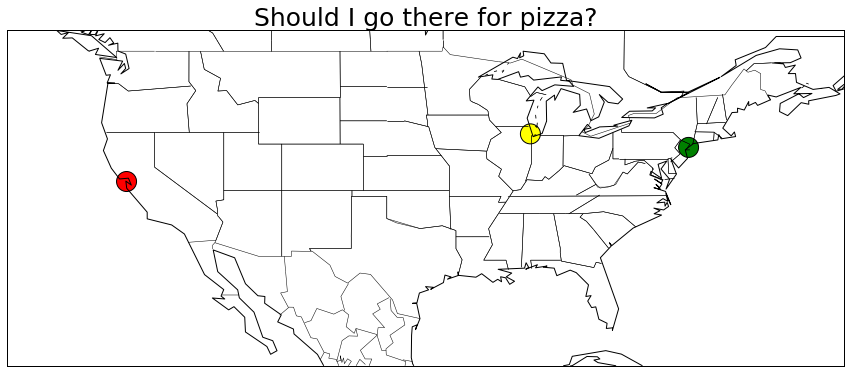

In [9]:
#We'll plug and chug, using some really basic boilerplate code 
#guilelessly stolen from Basemap's example gallery above: 

plt.figure(figsize = (15,10))

# set our lower-left and upper-right corners to whatever coordinates you got from 
# the bounding-box tool in the webpage above:
ll = (-132.7,21.9)  #THE 1ST AND 2ND PAIR OF COORDS FROM THE BBOX YOU DREW ABOVE
ur = (-60.6,50.8)

# create simplistic Basemap instance:
m = Basemap(llcrnrlon=ll[0],urcrnrlon=ur[0],\
            llcrnrlat=ll[1],urcrnrlat=ur[1])
# add coastlines, state and country borders
m.drawcoastlines()
m.drawstates()
m.drawcountries()

#plot our data on top!
colors = {'Y': 'green', '?': 'yellow', 'N':'red'}

plt.scatter(pizza['lon'], pizza['lat'],\
            c = [colors[val] for val in pizza['has_real_pizza']], s = 400)
plt.title('Should I go there for pizza?', fontsize = 25)
plt.show()




---------------------------

# Combining datasets

### Now, let's read in one each of four major spatial data types (points, lines, polygons, and rasters)

### We will use these to introspect common data formats

### Then we will work with them in combination, to demonstrate some common spatial operations

In [10]:
#First, let's create a separate subdirectory in our working directory, just for data:
data_dir = 'practice_data'

if data_dir not in os.listdir('.'):
    os.mkdir('./%s' % data_dir)

----------------------------
# Raster

### Briefly dowload, average, and plot some simple climate data behind the pizza data, simply to demonstrate how rasters work. Only about 10 - 15 minutes. Mention that a lot more can be done with rasters, but because of time constraints will be outside the purview of this workshop.

While we will not spend more time with raster data after this section of the workshop, it is important that we get some basic exposure to it.

Again, rasters are used to store regularly gridded spatial data (typically thought of as representing continuously spatially distributed variables).

Here, we will briefly download, load, and introspect the storage of some raster data.

# ___COMPLETE THIS___

# Vector Data

### Also aim for 10-15 minutes here, so that bulk of time can be spent on manipulation and use of polling/states/twitter data below!

Again, vector data can come in the form of points, lines, polygons, and multi-lines/multi-polygons.

Here, we will briefly download, load, and introspect the storage of some basic polygon data.

In [34]:
#We'll use fiona to read in shapefiles
#Simple, quick, easy, clean. 

#Importantly, this is one of the core Python spatial packages upon which the GeoPandas package 
#(which we'll be working with a bit later on) is built

IFrame('http://toblerity.org/fiona/manual.html', width = 1000, height = 700)

In [116]:
#Let's download a shapefile of California counties
urlretrieve('http://52.26.186.219/internships/useit/sites/scec.usc.edu.internships.useit/files/presentations/California%20County%20Shape%20Files.zip',\
            './%s/counties.zip' % data_dir)

#And again go unzip it...

('./practice_data/counties.zip',
 <httplib.HTTPMessage instance at 0x7efe0d499638>)

In [37]:
#Now let's open this file with Fiona
counties = fiona.open('./%s/California County Shape Files/County/CaliforniaCounty.shp' % data_dir, 'r') 

In [40]:
#Let's take a look at what properties each of the records in here possesses:
list(counties)[0]['properties']

OrderedDict([(u'STATEFP', u'06'),
             (u'COUNTYFP', u'107'),
             (u'COUNTYNS', u'00277318'),
             (u'GEOID', u'06107'),
             (u'NAME', u'Tulare'),
             (u'NAMELSAD', u'Tulare County'),
             (u'LSAD', u'06'),
             (u'CLASSFP', u'H1'),
             (u'MTFCC', u'G4020'),
             (u'CSAFP', None),
             (u'CBSAFP', u'47300'),
             (u'METDIVFP', None),
             (u'FUNCSTAT', u'A'),
             (u'ALAND', 12494707314.0),
             (u'AWATER', 37391604.0),
             (u'INTPTLAT', u'+36.2288317'),
             (u'INTPTLON', u'-118.7810618')])

In [42]:
#Now let's pull out a single geometric subunit and take a look:
test_coords = list(counties)[0]['geometry']['coordinates'][0]
test_coords[1:10]

[(-119.474935, 36.400439),
 (-119.474908, 36.40076),
 (-119.474892, 36.400953),
 (-119.482504, 36.401046),
 (-119.483927, 36.401038),
 (-119.484813, 36.401033999999996),
 (-119.487325, 36.401021),
 (-119.488638, 36.401007),
 (-119.492643, 36.400967)]

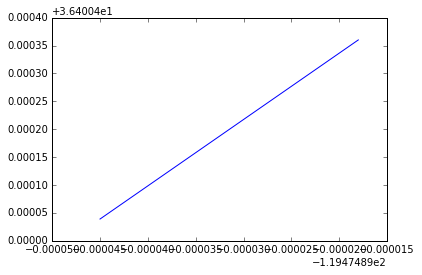

In [49]:
#What does this all mean?...
plt.plot([c[0] for c in test_coords[1:3]], [c[1] for c in test_coords[1:3]])

In [ ]:
plt.plot([c[0] for c in test_coords[1:10]], [c[1] for c in test_coords[1:10]])

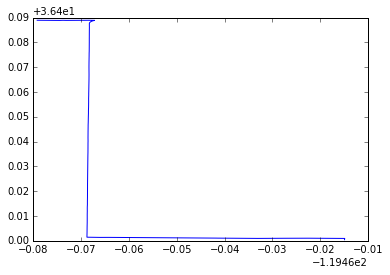

In [44]:
plt.plot([c[0] for c in test_coords[1:100]], [c[1] for c in test_coords[1:100]])

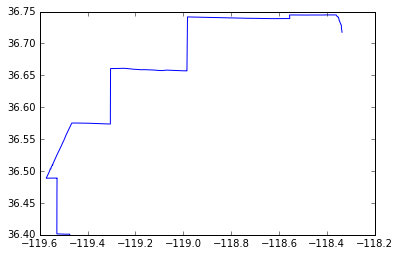

In [46]:
plt.plot([c[0] for c in test_coords[1:1000]], [c[1] for c in test_coords[1:1000]])

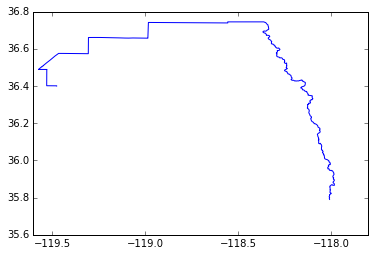

In [47]:
plt.plot([c[0] for c in test_coords[1:2500]], [c[1] for c in test_coords[1:2500]])

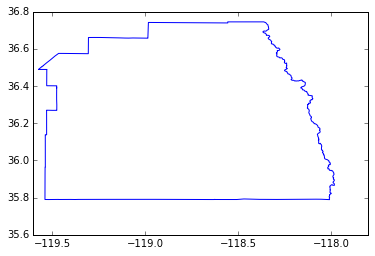

In [48]:
plt.plot([c[0] for c in test_coords], [c[1] for c in test_coords])

#You'll now notice that this differs from the fault lines in that it's a line that reconnects to its own beginning,
#i.e. a polygon!

----------------
# Raster

Show some demo of raster data?...

----------------
# Non-referenced spatial data

This is data that connects to spatial entities (in this case, states), but that will read in without actual geospatial references. We will merge this with proper geospatial data in order to be able to use its contents in spatial plots (i.e. maps) and analyses.

In [7]:
#Download presidential polling data
urlretrieve('http://www.electoral-vote.com/evp2016/Pres/pres_polls.csv', './%s/pres_polls.csv' % data_dir)

In [11]:
#And then read it in as a pandas dataframe
polls = pd.read_csv('./%s/pres_polls.csv' % data_dir)

In [87]:
#Get the average polling percentage for each of the two main parties, by state
state_mean_polls = pd.pivot_table(polls, index = 'State', aggfunc = np.mean)[['Dem', 'GOP']]

In [88]:
state_mean_polls.head()

,Dem,GOP
State,,
Alabama,34.750000,53.750000
Alaska,35.750000,45.875000
Arizona,41.071429,42.678571
Arkansas,35.272727,53.000000
California,53.387097,31.387097


In [100]:
state_mean_polls['advantage'] = [int(p) for p in list(state_mean_polls['GOP']/state_mean_polls['Dem'] > 1)]

In [101]:
state_mean_polls.head()

,Dem,GOP,advantage
State,,,
Alabama,34.750000,53.750000,1
Alaska,35.750000,45.875000,1
Arizona,41.071429,42.678571,1
Arkansas,35.272727,53.000000,1
California,53.387097,31.387097,0


----------------
# Polygons

# __DO THE SAME AS BELOW, BUT CHANGE TO USING GEOPANDAS AND INTROSPECTING ONE OF THE GEOMETRIES__

# __THEN USE THIS AND THE POINTS/LINES TO DEMO SOME COMMON SPATIAL OPERATIONS, MOSTLY IN GEOPANDAS FUNCTIONS__

Polygon data are very common, often being used to represent borders of areas, jurisdictions, land masses, etc.

Common polygon operations (some of which we will demonstrate) include:
- joins
- point extractions
- merges
- overlays and raster calculations
- etcetera

In [31]:
#Download a US states shapefile
urlretrieve('http://www2.census.gov/geo/tiger/GENZ2015/shp/cb_2015_us_state_500k.zip', './%s/states.zip' % data_dir)

#Now go unzip it!...

('./practice_data/states.zip',
 <httplib.HTTPMessage instance at 0x7f5683067d88>)

In [12]:
states = gpd.read_file('./%s/cb_2015_us_state_500k.shp' % data_dir)

In [13]:
states.head()

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry
0,0400000US31,1.989724e+11,1.356295e+09,31,00,Nebraska,31,01779792,NE,"POLYGON ((-104.053418545071 41.1705389679833, ..."
1,0400000US53,1.721210e+11,1.254009e+10,53,00,Washington,53,01779804,WA,"(POLYGON ((-122.33164 48.020556, -122.328343 4..."
2,0400000US35,3.141614e+11,7.556740e+08,35,00,New Mexico,35,00897535,NM,"POLYGON ((-109.050173 31.480004, -109.049843 3..."
3,0400000US46,1.963494e+11,3.379811e+09,46,00,South Dakota,46,01785534,SD,"POLYGON ((-104.057698 44.997431, -104.049505 4..."
4,0400000US21,1.022663e+11,2.389483e+09,21,00,Kentucky,21,01779786,KY,"(POLYGON ((-89.405654 36.528165, -89.398685 36..."


In [18]:
#First, let's introspect the structure that stores a polygon
samp_poly = states['geometry'][0]

In [33]:
#HOW TO GET INTO THIS??

False

In [104]:
#Check if we have only 50 matches between our polling data and our states shapefile (this could differ it 
#there are spelling errors, or if there invisible line breaks or spaces included in the state names, etc.)
len([n for n, st in enumerate(list(states['NAME'])) if str(st) in list(state_mean_polls.index)])

50

In [105]:
#set the states index to the state names (i.e. NAME column)
states = states.set_index('NAME')



In [106]:
states = pd.concat([states, state_mean_polls], axis=1, join='inner')

In [107]:
#Check that it worked the way we wanted it to
len(states)

50

In [108]:
states.head()

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,STATEFP,STATENS,STUSPS,geometry,Dem,GOP,advantage
Alabama,0400000US01,1.311734e+11,4.593985e+09,01,00,01,01779775,AL,"(POLYGON ((-88.053375 30.506987, -88.051087999...",34.750000,53.750000,1
Alaska,0400000US02,1.477946e+12,2.453917e+11,02,00,02,01785533,AK,"(POLYGON ((-177.466812 51.904003, -177.464905 ...",35.750000,45.875000,1
Arizona,0400000US04,2.942045e+11,1.027559e+09,04,00,04,01779777,AZ,"POLYGON ((-114.816294 32.508038, -114.814321 3...",41.071429,42.678571,1
Arkansas,0400000US05,1.347693e+11,2.962525e+09,05,00,05,00068085,AR,"POLYGON ((-94.6178329666013 36.4994141203285, ...",35.272727,53.000000,1
California,0400000US06,4.034890e+11,2.047799e+10,06,00,06,01779778,CA,"(POLYGON ((-118.604415 33.478552, -118.598783 ...",53.387097,31.387097,0


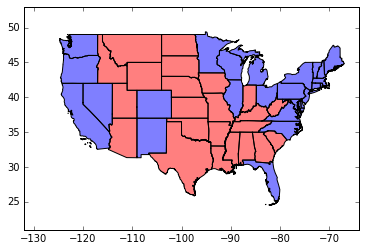

In [461]:
#Great! Now let's use our advantage column to create a grossly over-simplified choropleth map:

#Scrolling back up to our bbox tool to get a simplifying bounding box around just the continental states gives us:
#-131.1,21.8,-64.3,52.4

axes = plt.gca()
axes.set_xlim([-132,-64])
axes.set_ylim([21,53])
states.plot(column = 'advantage', figsize = (15,10), ax = axes, cmap = 'bwr')#color_kwds = {1:'red', 0:'blue'})




----------------
# Points

Tweets containing 'quake' or 'tremor'

# __DOWNLOAD TWEETS,INTROSPECT, DEMO THE LAT/LON COMPONENTS, THEN USE THIS TO INTRODUCE GEOPANDAS AND CREATE A GEOPANDAS GEODATAFRAME__

In [495]:
#Now, let's create a spatial dataset to look at the proportions of tweets about the dis-advantaged candidate
#in each state, for the week leading up to the election (10/31/16 - 11/07/16)

#First, set up our Twitter authentication
with open('/home/ihavehands/Desktop/DEH_creds.yml', 'r') as f:
    creds = yaml.load(f)


twitter = OAuth1Session(**creds)

search = "https://api.twitter.com/1.1/search/tweets.json"

In [483]:
#test API request
test_tweets = twitter.get(search, params={
            'q' : 'Donald OR Trump :)',  
            #containing Hillary and/or Clinton (but not Bill), and with a negative attitude
            'geocode' : '39.8000000,-98.5000000,2000mi',
            'count' : '100',
            'max_id': '792715297925001215'
        })

In [484]:
#Also, we'll need to play with the min and max ID values for the strings of tweets returned each time, 
#since we only get batches of max 100

#So here's how we return the max_id from a set of tweets
clinton_pos.json()['search_metadata']['max_id']

796143470855462913

In [485]:
#And this will return the min
min([st['id'] for st in clinton_pos.json()['statuses']])

796128726090129412

In [529]:
geocoder = GoogleV3()
c_pos = []
c_neg = []
t_pos = []
t_neg = []
coords = (c_pos, c_neg, t_pos, t_neg)

In [542]:

def get_tweets(max_id):
    #A search for geolocated tweets within 2000 miles of the cetner of the USA 
    #(a Google search for the centroid returns 39°50′N 98°35′W) should give us tweets covering the 48 continental states

    #We'll conduct separate searches for Clinton and Trump, to refine them each a bit
    #Remember that there is a full list of query options at: https://dev.twitter.com/rest/public/search

    sp_range = '39.8000000,-98.5000000,2000mi'
    ct = '10'  #NOTE: Change to max (100) for accumulation of real data
    
    #Clinton data:
    print('retrieving c_p...')
    clinton_pos = twitter.get(search, params={
            'q' : 'Hillary OR Clinton -Bill :)',  
            #containing Hillary and/or Clinton (but not Bill), and with a positive attitude
            'geocode' : sp_range,
            'count' : ct,
            'max_id': max_id[0]
        })
    print('\t' + str(len(clinton_pos.json()['statuses'])))
    
    print('retrieving c_n...')
    clinton_neg = twitter.get(search, params={
            'q' : 'Hillary OR Clinton -Bill :(',  
            #containing Hillary and/or Clinton (but not Bill), and with a negative attitude
            'geocode' : sp_range,
            'count' : ct,
            'max_id': max_id[1]
        })
    print('\t' + str(len(clinton_neg.json()['statuses'])))
    
    print('retrieving t_p...')
    trump_pos = twitter.get(search, params={
            'q' : 'Donald OR Trump :)',  
            #containing Donald and/or Trump, and with a positive attitude
            'geocode' : sp_range,
            'count' : ct,
            'max_id': max_id[2]
        })
    print('\t' + str(len(trump_pos.json()['statuses'])))
    
    print('retrieving t_n...')
    trump_neg = twitter.get(search, params={
            'q' : 'Donald OR Trump :(',  
            #containing Donald and/or Trump, and with a negative attitude
            'geocode' : sp_range,
            'count' : ct,
            'max_id': max_id[3]
        })
    print('\t' + str(len(trump_neg.json()['statuses'])))

    #FOR QUICK DEBUGGING OF TWITTER AUTH ISSUES:
    #print(clinton_pos.status_code, clinton_pos.reason)
    #print(clinton_neg.status_code, clinton_neg.reason)
    #print(trump_pos.status_code, trump_pos.reason)
    #print(trump_neg.status_code, trump_neg.reason)
    
    #Because of these lines, a loop should essentially run until this evaluates to False,
    #Which is most likely to happen if our account is locked because of rate or day-rate limiting
    assert clinton_pos.ok 
    assert clinton_neg.ok
    assert trump_pos.ok
    assert trump_neg.ok
    
    return (clinton_pos, clinton_neg, trump_pos, trump_neg)
    
    
#function to get locations from tweets    
def get_locs(tweets):
    locs = []
    for s in tweets.json()['statuses']:
        try:
            locs.append(s['user']['location'])
        except Exception:
            pass
    print('loc length' + str(len(locs)))
    return locs
        
        

#function to geocode locations
def get_coords(locs):
    coord_list = []
    for loc in locs:
        try:
            code = geocoder.geocode(loc)
            coord_list.append((code.longitude, code.latitude))
        except Exception:
            pass
    return coord_list


#function to knit them all together, returning geolocations for tweets
def find_tweet_locs(max_id):
    tweets = get_tweets(max_id)
    
    for n, tweet_set in enumerate(tweets):
        if len(tweet_set.json()['statuses']) > 0:
            coords[n].extend(get_coords(get_locs(tweet_set)))
        
            #set the new max_ids == min_ids from previous search, separately for each of the four searches
            print(n, ': ', min([st['id'] for st in tweet_set.json()['statuses']])) 
            max_id[n] = str(min([st['id'] for st in tweet_set.json()['statuses']])-1)
            #Subtract one from the min_id, b/c max_id is inclusive; see https://dev.twitter.com/rest/public/timelines

#final function, to loop for a given number of times, dumping coordinates into the containers created above
def loop_find_tweet_locs(n, max_id = None):
    if max_id == None:
        max_id = ['1000000000000000000000000000000000000'] * 4   #Starting max_id at a value way above the most recent tweet
    print('Starting max_id: ', max_id)
    for i in range(n):
        print('loop number %i' % i)
        find_tweet_locs(max_id)
        print max_id
    return max_id 
    #Will give us back to max_id vector at the end, in case we want to run more searches later and continue to accrue results
        

In [543]:
[len(coords[i]) for i in range(1)] #NOTE: Change to larger number of iterations to collection of full data

[0, 0, 0, 0]

In [544]:
#Now run our function 5 times to try it out!
last_max_id = loop_find_tweet_locs(1)
#last_max_id = loop_find_tweet_locs(25, max_id = last_max_id)

('Starting max_id: ', ['1000000000000000000000000000000000000', '1000000000000000000000000000000000000', '1000000000000000000000000000000000000', '1000000000000000000000000000000000000'])
loop number 0
retrieving c_p...
	100
retrieving c_n...
	100
retrieving t_p...
	90
retrieving t_n...
	100
loc length100
(0, ': ', 796147322690424833)
loc length100
(1, ': ', 796119078679277569)
loc length90
(2, ': ', 796154158474739713)
loc length100
(3, ': ', 796147389547610113)
['796147322690424832', '796119078679277568', '796154158474739712', '796147389547610112']


In [545]:
[len(coords[i]) for i in range(4)]

[0, 0, 0, 0]

#### TAKE A BRIEF LOOK AT WHAT WE DOWNLOADED

#### THEN EXPLAIN THAT BECAUSE OF RATE-LIMITING AND TIME CONSTRAINTS, I'VE COMPILED A LARGE DATASET THIS WAY
#### AND SAVED IT AS A pickle, WHICH WE WILL NOW READ IN AND USE FOR ANALYSIS

In [ ]:
#Read in pickled coordinates data from Tweets


In [ ]:
#Check sample sizes (i.e. lengths)

In [513]:
#Create a GeoSeries of spatial points from the tweet coordinates
pts = []
for n, pt_set in enumerate(coords):
    pts.append(gpd.GeoSeries([Point(x, y) for x, y in pt_set]))
    
#pts.intersects(states['geometry'].unary_union)
    
#figure out how to sum by polygon

#then calculate proportion negative comments dis-advantaged to positive comments advantaged by state


In [514]:
#Add columns to states gdf tally counts for each of the 4 twitter searches
states['c_p'] = 0
states['c_n'] = 0
states['t_p'] = 0
states['t_n'] = 0

In [517]:
#Save the four categories (i.e. positive and negative tweet-sentiment for each candidate) as a reference list, in
#matching order to other code above
cats = ['c_p', 'c_n', 't_p', 't_n']

#Now check polygon intersecting with each tweet's coordinate, and add one tweet in the appropriate category 
#(i.e. column) of the appropriate state (i.e. row) in our GeoDataFrame
for n, cat in enumerate(cats):
    pt_set = pts[n]
    for pt in pt_set:
        int_list = states['geometry'].intersects(pt)
        #print(int_list[int_list == True])
        try:
            int_st = [str(int_list[int_list == True].index[0])]
            #states.ix[int_st][cat] = states.ix[int_st][cat] + 1
            states = states.set_value(int_st, cat, states.ix[int_st][cat]+1)
        except Exception:
            pass

4


In [518]:
#Check that it seems to have worked out
states.head()

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,STATEFP,STATENS,STUSPS,geometry,Dem,GOP,advantage,c_p,c_n,t_p,t_n,voter_affect,abs_voter_affect
Alabama,0400000US01,1.311734e+11,4.593985e+09,01,00,01,01779775,AL,"(POLYGON ((-88.053375 30.506987, -88.051087999...",34.750000,53.750000,1,0,0,0,0,-0.500000,0.500000
Alaska,0400000US02,1.477946e+12,2.453917e+11,02,00,02,01785533,AK,"(POLYGON ((-177.466812 51.904003, -177.464905 ...",35.750000,45.875000,1,0,0,0,0,NaN,NaN
Arizona,0400000US04,2.942045e+11,1.027559e+09,04,00,04,01779777,AZ,"POLYGON ((-114.816294 32.508038, -114.814321 3...",41.071429,42.678571,1,0,0,0,0,-1.000000,1.000000
Arkansas,0400000US05,1.347693e+11,2.962525e+09,05,00,05,00068085,AR,"POLYGON ((-94.6178329666013 36.4994141203285, ...",35.272727,53.000000,1,0,0,0,0,NaN,NaN
California,0400000US06,4.034890e+11,2.047799e+10,06,00,06,01779778,CA,"(POLYGON ((-118.604415 33.478552, -118.598783 ...",53.387097,31.387097,0,0,0,0,0,0.333333,0.333333


In [474]:
#Now write a function to calculate the 'tweet-sentiment skew' (pro-favored versus anti-unfavored) in each state

#state_colors = {1:'red', 0:'blue'} 

#reference dictionary of the two categories used to calculate skew, depending on the party advantage indicated
#by the polling data of a state
adv_supp_disadv_attack_vars = {1: ('t_p', 'c_n'),
                               0: ('c_p', 't_n')
                              }

#function to calculate the tweet-sentiment skew
def tweet_sentiment_skew(adv_support, disadv_attack):   
    #0.5 == even (i.e. null) split between advatage-supportive and disadvantage-attacking tweets
    return float(disadv_attack) / (adv_support + disadv_attack) #Constrained to a value between 0 and 1


#function to calculate our skew index for all sates
def calc_skew(row):
    state = row.name
    st_col = state_colors[row['advantage']]
    tweet_vars = adv_supp_disadv_attack_vars[row['advantage']]
    try:
        skew = tweet_sentiment_skew(row[tweet_vars[0]], row[tweet_vars[1]])
        if row['advantage'] == 1:
            skew = -1*skew   #This will distribute affect values between -1 and 0 in red states, 
                             #and between 0 and 1 in blue states,
                             #so that plotting lines works out right with the colormap
    except ZeroDivisionError:
        skew = np.NaN
    
    return skew

states['skew'] = states.apply(calc_skew, axis = 1)

states['abs_skew'] = [np.abs(v_a) for v_a in states['skew']]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in absolute


In [475]:
#Again, a quick check that it seems to have worked 
#(Note: I have calculated a couple states by hand and checked against the output)
states.head()

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,STATEFP,STATENS,STUSPS,geometry,Dem,GOP,advantage,c_p,c_n,t_p,t_n,voter_affect,abs_voter_affect
Alabama,0400000US01,1.311734e+11,4.593985e+09,01,00,01,01779775,AL,"(POLYGON ((-88.053375 30.506987, -88.051087999...",34.750000,53.750000,1,0,2,2,1,-0.500000,0.500000
Alaska,0400000US02,1.477946e+12,2.453917e+11,02,00,02,01785533,AK,"(POLYGON ((-177.466812 51.904003, -177.464905 ...",35.750000,45.875000,1,0,0,0,0,NaN,NaN
Arizona,0400000US04,2.942045e+11,1.027559e+09,04,00,04,01779777,AZ,"POLYGON ((-114.816294 32.508038, -114.814321 3...",41.071429,42.678571,1,0,2,0,3,-1.000000,1.000000
Arkansas,0400000US05,1.347693e+11,2.962525e+09,05,00,05,00068085,AR,"POLYGON ((-94.6178329666013 36.4994141203285, ...",35.272727,53.000000,1,0,0,0,0,NaN,NaN
California,0400000US06,4.034890e+11,2.047799e+10,06,00,06,01779778,CA,"(POLYGON ((-118.604415 33.478552, -118.598783 ...",53.387097,31.387097,0,16,10,8,8,0.333333,0.333333


/usr/local/lib/python2.7/dist-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "box_plot". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)


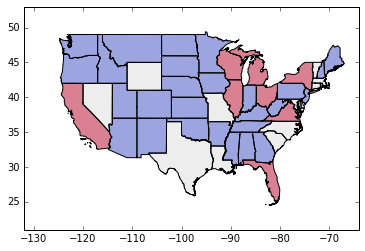

In [479]:
axes = plt.gca()
axes.set_xlim([-132,-64])
axes.set_ylim([21,53])
#NOTE: WHAT IS THE BEST COLORMAP TO USE? (WANT TO ENSURE THAT 0 IS FIXED AT WHITE)
states.plot(column = 'voter_affect', figsize = (15,10), ax = axes, cmap = 'coolwarm', scheme = 'equal_interval') #, legend = True)

In [473]:
from scipy import stats

#Does this index of voter affect differ significantly between red and blue states??

red_affect = [val for val in states[states['advantage'] == 1]['abs_voter_affect'] if not np.isnan(val)]
blue_affect = [val for val in states[states['advantage'] == 0]['abs_voter_affect'] if not np.isnan(val)]
print('mean red affect: ', np.mean(red_affect))
print('mean blue affect: ', np.mean(blue_affect))
stats.ttest_ind(red_affect, blue_affect)

('mean red affect: ', 0.5270815928710666)
('mean blue affect: ', 0.33686067019400345)


(1.4520071263902885, 0.15654628778007998)